# Introduction

I created this project not only to show the ease of use and power of Pynq, but also to have a way to monitor the environmental conditions of my viola. 

The Pmod used in this project is the Pmod Hygro, which I have provided a link to in my hackster page. The Pmod Hygro uses the I2C communication protocol, and luckily, after some research in the deocumentation, you can use the Microblaze IP to interact with the pmod ports and control your Pmods using C code. 

This section imports the necessary overlays, libraries, etc to get started on this project. 
%matplotlib notebook is a magic command that allows IPython to work hand in hand with matplot lib (to do real time update of graphs).

In [1]:
%matplotlib notebook

from pynq.overlays.base import BaseOverlay
from mpl_toolkits.axes_grid1 import make_axes_locatable
import time
import matplotlib.pyplot as plt
import matplotlib.animation as animation
import datetime as dt

# Base Overlay 

This imports the base overlay of the Pynq design. This overlay is the underlying hardware design of the board(bitfile generated in Vivado that contains all the IP). This is where the microblaze is configured that will allow you to control your pmods. 

In [2]:
base = BaseOverlay("base.bit")

# Pynq Microblaze

Microblaze is a soft-core processor implemented in the FPGA logic that will allow you to run C code on your FPGA.
This microblaze will read and write to registers in the PMOD port that is given (PMOD A is used in this example). 
The i2c object used throughout is a library built into the Microblaze that will allow you to interface easily with I2C peripherals. More information can be found in the pynq microblaze section of the documentation page. 

There are delays in the read commands, and those are to allow the pmod to convert the data. If the register is read before the data is converted and written onto the reg, then it will issue another conversion adn you will not get correct data. Read more from the Pmod Hygro documentation. 

Pmod Hygro Doc: https://reference.digilentinc.com/_media/reference/pmod/pmodhygro/pmod-hygro-rm.pdf

I2C Microblaze Library: https://pynq.readthedocs.io/en/v2.4/pynq_libraries/pynqmb_reference.html#void-i2c-write-i2c-dev-id-unsigned-int-slave-address-unsigned-char-buffer-unsigned-int-length

Pmod Port General Information: https://pynq.readthedocs.io/en/v2.3/pynq_libraries/pmod.html

Microblaze Timer Devices: https://pynq.readthedocs.io/en/v2.3/pynq_libraries/pynqmb_reference.html?highlight=timer#timer-devices

In [3]:
%%microblaze base.PMODA 
#include <i2c.h>
#include <timer.h>

#define I2C_Addr 0x40 
#define reg_humid 0x1
#define reg_temp 0x0
#define I2C_SDA 7
#define I2C_SCL 6
#define delay 15

//PMOD Location: PMODA, Lower Row 
//PMOD Pins: SDA = 7, SCL = 6
unsigned char buf_temp[2]; //1 char = 8 bits.
unsigned char buf_humid[2]; 

i2c device = i2c_open(I2C_SDA, I2C_SCL); //open i2c device using SCL and SDA pins on low row of PMODA

//reads from temp reg 0x00 (16-bit read-only reg)
int read_temp() {   
    buf_temp[0] = reg_temp;
    delay_ms(delay);
    i2c_write(device, I2C_Addr, buf_temp, 1); //address of register I want to read from is in buf
    delay_ms(delay);
    i2c_read(device, I2C_Addr, buf_temp, 2); //read 16 bytes from temp register. bits 0 and 1 are garbage
    return (((((buf_temp[0]<<8)|buf_temp[1])*165)/(1<<16))-45); //conversion of data to readable temperature
}

//read from humid reg 0x01 (16-bit read-only reg)
int read_humid() {
    buf_humid[0] = reg_humid;
    delay_ms(delay);
    i2c_write(device, I2C_Addr, buf_humid, 1); //address of register I want to read from is in buf
    delay_ms(delay);
    i2c_read(device, I2C_Addr, buf_humid, 2); //read 16 bytes from temp registe. bits 0 and 1 are garbage
    return ((((buf_humid[0]<<8)|buf_humid[1])*100)/(1<<16)); //conversion of data to readable temperature
}

# Reading and Plotting in Real Time

Much of the code written here sets up the plotting library, in our case, matplotlib. The FuncAnimation function will allow the data being read in to be displayed on a graph in real time. 

https://learn.sparkfun.com/tutorials/graph-sensor-data-with-python-and-matplotlib/update-a-graph-in-real-time

<IPython.core.display.Javascript object>


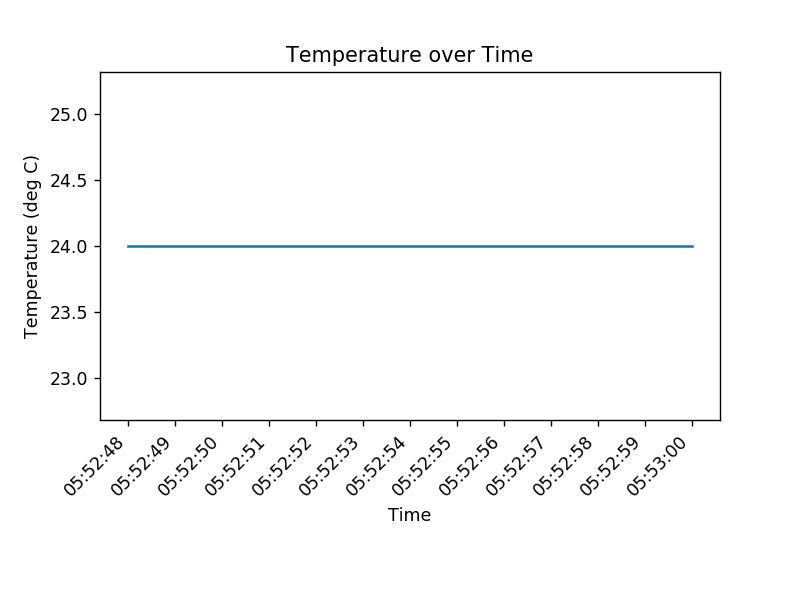

In [8]:
# Create figure for plotting temperature
fig = plt.figure()
ax = fig.add_subplot(1, 1, 1)
xs = []
ys = []

# This function is called periodically from FuncAnimation
def temp_animate(i, xs, ys):
    # Read temperature (Celsius) 
    temp_c = round(read_temp(), 2)

    # Add x and y to lists
    xs.append(dt.datetime.now().strftime('%H:%M:%S'))
    ys.append(temp_c)

    # Limit x and y lists to 20 items
    xs = xs[-20:]
    ys = ys[-20:]

    # Draw x and y lists
    ax.clear()
    ax.plot(xs, ys)

    # Format plot
    plt.xticks(rotation=45, ha='right')
    plt.subplots_adjust(bottom=0.30)
    plt.title('Temperature over Time')
    plt.ylabel('Temperature (deg C)')
    plt.xlabel('Time')


# Set up plot to call animate() function periodically
ani = animation.FuncAnimation(fig, temp_animate, fargs=(xs, ys), interval=1000) #1000ms = 1s to delay for conversion. 
plt.show()

In [ ]:
# Create figure for plotting humidity 
fig = plt.figure()
ax = fig.add_subplot(1, 1, 1)

xs = []
ys = []

def humid_animate(i, xs, ys):
    # Read temperature (Celsius) 
    humid = read_humid()

    # Add x and y to lists
    xs.append(dt.datetime.now().strftime('%H:%M:%S'))
    ys.append(humid)

    # Limit x and y lists to 20 items
    xs = xs[-20:]
    ys = ys[-20:]

    # Draw x and y lists
    ax.clear()
    ax.plot(xs, ys)

    # Format plot
    plt.xticks(rotation=45, ha='right')
    plt.subplots_adjust(bottom=0.30)
    plt.title('Humidity over Time')
    plt.ylabel('Percentage Humidity')
    plt.xlabel('Time')

# Set up plot to call animate() function periodically
ani2 = animation.FuncAnimation(fig, humid_animate, fargs=(xs, ys), interval=1000) #1000ms = 1s to delay for conversion. 

plt.show()